# Install Dependencies

In [1]:
!pip install torch_summary

# Import Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 

from sklearn.metrics import classification_report, recall_score
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2
from glob import glob
import pandas as pd

In [3]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data

In [4]:
DIR = '../input/140k-real-and-fake-faces/'
train_df = pd.read_csv(f'{DIR}train.csv', index_col=0)
valid_df = pd.read_csv(f'{DIR}valid.csv', index_col=0)
train_df.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


In [5]:
def label_split(df, size, fake_size, random_state=4012):
    real_size = 1 - fake_size
    real_size = int(real_size * size)
    fake_size = int(fake_size * size)
    fake_df = df[df['label'] == 0]
    real_df = df[df['label'] == 1]
    sub_fake_df = fake_df.sample(fake_size, random_state=random_state)
    sub_real_df = real_df.sample(real_size, random_state=random_state)
    new_df = pd.concat([sub_fake_df, sub_real_df])
    new_df = new_df.sample(frac=1, random_state=random_state)
    return new_df.reset_index(drop=True)

In [6]:
train_df = label_split(train_df, 10000, 0.05)
valid_df = label_split(valid_df, 2500, 0.05)

<BarContainer object of 2 artists>

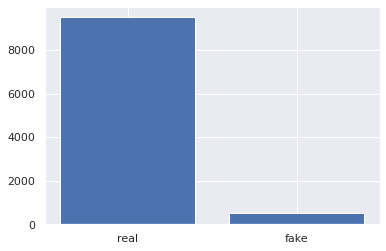

In [7]:
train_label = train_df['label_str'].value_counts()
plt.bar(train_label.index, train_label.values)

In [8]:
class FaceDataset(Dataset):
    def __init__(self, df, DIR="../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"):
        super().__init__()
        self.df = df
        self.DIR = DIR
        self.transform = T.Compose([
            T.Resize([299, 299]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), 
                        (0.229, 0.224, 0.225))
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ind):
        row = self.df.iloc[ind]
        img_path = self.DIR + row['path']
        img = Image.open(img_path).convert('RGB')
        target = row['label']
        return img, target
    
    def get_real_img(self):
        real_img_ind = self.df[self.df['label'] == 1].index
        target_ind = choice(real_img_ind)
        return self[target_ind]
    
    def get_fake_img(self):
        real_img_ind = self.df[self.df['label'] == 0].index
        target_ind = choice(real_img_ind)
        return self[target_ind]
    
    def choose(self):
        return self[randint(0, len(self)-1)]
    
    def decode(self, target):
        return ['fake', 'real'][target]
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        )
        return imgs.to(device), targets.to(device)

In [9]:
train_ds = FaceDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,
                      collate_fn=train_ds.collate_fn, 
                      drop_last=True)
valid_ds = FaceDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=64,
                      collate_fn=valid_ds.collate_fn)

In [10]:
print('Size of Train:', len(train_ds))
print('Size of Validation:', len(valid_ds))

Size of Train: 10000
Size of Validation: 2500


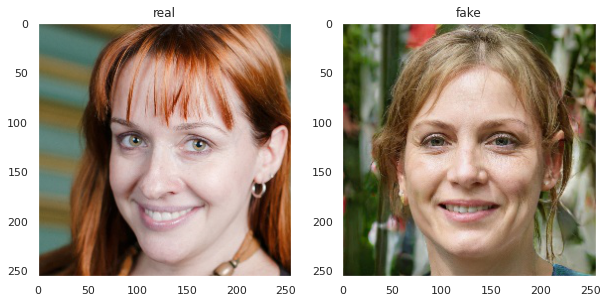

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))

# real
img, target = train_ds.get_real_img()
label = train_ds.decode(target)
ax[0].imshow(img)
ax[0].title.set_text(label)
ax[0].grid(False)

# fake
img, target = train_ds.get_fake_img()
label = train_ds.decode(target)
ax[1].imshow(img)
ax[1].title.set_text(label)
ax[1].grid(False)

plt.show()

## Model

In [12]:
class FaceClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = models.inception_v3(pretrained=pretrained, progress=pretrained)
        for param in self.backbone.parameters():
            param.requires_grad = True
        
        aux_num_features = self.backbone.AuxLogits.fc.in_features
        self.backbone.AuxLogits.fc = nn.Sequential(
            nn.Linear(aux_num_features, 1),
            nn.Sigmoid()
        )
        
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [13]:
classifier = FaceClassifier(pretrained=False)
_ = summary(classifier, torch.ones(1,3,299,299))

/opt/conda/lib/python3.7/site-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


Layer (type:depth-idx)                   Output Shape              Param #
├─Inception3: 1-1                        [-1, 1]                   --
|    └─BasicConv2d: 2-1                  [-1, 32, 149, 149]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 149, 149]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 149, 149]        64
|    └─BasicConv2d: 2-2                  [-1, 32, 147, 147]        --
|    |    └─Conv2d: 3-3                  [-1, 32, 147, 147]        9,216
|    |    └─BatchNorm2d: 3-4             [-1, 32, 147, 147]        64
|    └─BasicConv2d: 2-3                  [-1, 64, 147, 147]        --
|    |    └─Conv2d: 3-5                  [-1, 64, 147, 147]        18,432
|    |    └─BatchNorm2d: 3-6             [-1, 64, 147, 147]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 73, 73]          --
|    └─BasicConv2d: 2-5                  [-1, 80, 73, 73]          --
|    |    └─Conv2d: 3-7                  [-1, 80, 73, 73]          5,120
|  

# Train

In [14]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs, aux_outputs = classifier(imgs)
    aux_loss = loss_fn(aux_outputs, targets)
    loss = loss_fn(outputs, targets)
    total_loss = 0.4 * aux_loss + loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return total_loss.cpu().detach().item(), fake_recall

In [15]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return loss.cpu().detach().item(), fake_recall

In [16]:
n_epochs = 15
xticks = list(i+1 for i in range(n_epochs))

## BCE Loss

In [17]:
classifier = FaceClassifier(pretrained=False).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5,
                                      gamma=0.25)
best_recall = 0

In [18]:
mem = {
    'train_loss': [],
    'train_recall': [],
    'valid_loss': [],
    'valid_recall': []
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recalls = [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall = train(data, classifier,
                                         optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recalls.append(train_recall)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall:', "%.3f" % train_recall, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall'].append(np.mean(train_recalls))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recalls = [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recalls.append(valid_recall)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall:', "%.3f" % valid_recall, 
            end='\r'
        )
    
    cur_recall = np.mean(valid_recalls)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall'].append(cur_recall)
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall:', "%.3f" % mem['train_recall'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall:', "%.3f" % mem['valid_recall'][-1],
    )
    
    if best_recall < cur_recall:
        best_recall = cur_recall
        torch.save(classifier.state_dict(), './saved_model/base_inception_bce_weights.pth')
        
    scheduler.step()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.297 	train recall: 0.004 	valid loss: 0.201 	valid recall: 0.000
epoch: 2 	train loss: 0.285 	train recall: 0.000 	valid loss: 0.193 	valid recall: 0.000
epoch: 3 	train loss: 0.277 	train recall: 0.000 	valid loss: 0.206 	valid recall: 0.000
epoch: 4 	train loss: 0.272 	train recall: 0.000 	valid loss: 0.187 	valid recall: 0.000
epoch: 5 	train loss: 0.267 	train recall: 0.003 	valid loss: 0.205 	valid recall: 0.000
epoch: 6 	train loss: 0.242 	train recall: 0.019 	valid loss: 0.177 	valid recall: 0.020
epoch: 7 	train loss: 0.226 	train recall: 0.057 	valid loss: 0.186 	valid recall: 0.120
epoch: 8 	train loss: 0.204 	train recall: 0.174 	valid loss: 0.173 	valid recall: 0.189
epoch: 9 	train loss: 0.185 	train recall: 0.240 	valid loss: 0.189 	valid recall: 0.105
epoch: 10 	train loss: 0.165 	train recall: 0.348 	valid loss: 0.167 	valid recall: 0.200
epoch: 11 	train loss: 0.091 	train recall: 0.679 	valid loss: 0.191 	valid recall: 0.220
epoch: 12 	train lo

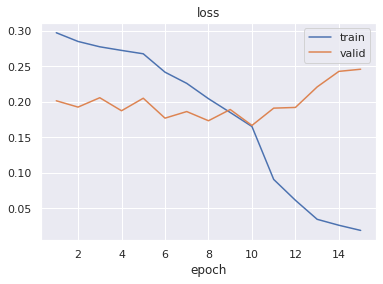

In [19]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

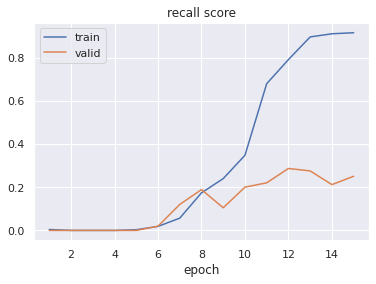

In [20]:
plt.plot(xticks, mem['train_recall'])
plt.plot(xticks, mem['valid_recall'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()

## Focal Loss

In [21]:
def focal_loss(alpha=0.25, gamma=2, reduce='mean'):
    def helper(preds, targets):
        bce_loss = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')
        pt = preds * targets + (1 - preds) * (1 - targets)
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        F_loss = alpha_t * ((1-pt)**gamma) * bce_loss
        if reduce == 'mean':
            return F_loss.mean()
        elif reduce == 'sum':
            return F_loss.sum()
    return helper

In [22]:
classifier = FaceClassifier(pretrained=False).to(device)
loss_fn = focal_loss(alpha=0.05)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5,
                                      gamma=0.25)
best_recall = 0

/opt/conda/lib/python3.7/site-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [23]:
mem = {
    'train_loss': [],
    'train_recall': [],
    'valid_loss': [],
    'valid_recall': []
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recalls = [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall = train(data, classifier,
                                         optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recalls.append(train_recall)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall:', "%.3f" % train_recall, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall'].append(np.mean(train_recalls))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recalls = [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recalls.append(valid_recall)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall:', "%.3f" % valid_recall, 
            end='\r'
        )
    
    cur_recall = np.mean(valid_recalls)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall'].append(cur_recall)
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall:', "%.3f" % mem['train_recall'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall:', "%.3f" % mem['valid_recall'][-1],
    )
    
    if best_recall < cur_recall:
        best_recall = cur_recall
        torch.save(classifier.state_dict(), './saved_model/base_inception_fl_weights.pth')
        
    scheduler.step()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.024 	train recall: 0.866 	valid loss: 0.017 	valid recall: 0.798
epoch: 2 	train loss: 0.023 	train recall: 0.904 	valid loss: 0.015 	valid recall: 0.975
epoch: 3 	train loss: 0.022 	train recall: 0.903 	valid loss: 0.016 	valid recall: 0.975
epoch: 4 	train loss: 0.022 	train recall: 0.899 	valid loss: 0.015 	valid recall: 0.847
epoch: 5 	train loss: 0.022 	train recall: 0.912 	valid loss: 0.016 	valid recall: 0.899
epoch: 6 	train loss: 0.020 	train recall: 0.878 	valid loss: 0.015 	valid recall: 0.852
epoch: 7 	train loss: 0.020 	train recall: 0.810 	valid loss: 0.014 	valid recall: 0.783
epoch: 8 	train loss: 0.019 	train recall: 0.845 	valid loss: 0.014 	valid recall: 0.830
epoch: 9 	train loss: 0.018 	train recall: 0.815 	valid loss: 0.014 	valid recall: 0.825
epoch: 10 	train loss: 0.017 	train recall: 0.843 	valid loss: 0.014 	valid recall: 0.870
epoch: 11 	train loss: 0.016 	train recall: 0.894 	valid loss: 0.014 	valid recall: 0.777
epoch: 12 	train lo

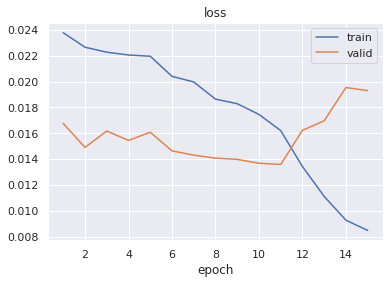

In [24]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

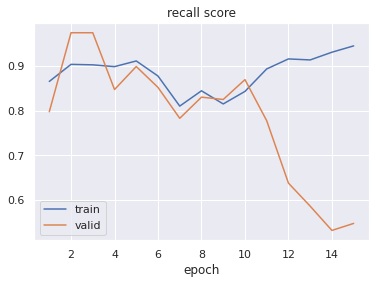

In [25]:
plt.plot(xticks, mem['train_recall'])
plt.plot(xticks, mem['valid_recall'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()